In [1]:
import pandas as pd
import numpy as np

# 1035, 258
train = pd.read_csv('/Users/bdlab/Desktop/sparse-matrix-multiplication/scenario-extraction/d-optimal/spmm-latency-traintest/train-test-csv/nonsquare-train-1035-from-spmm-contain-todense-over-3s-1293.csv')
test = pd.read_csv('/Users/bdlab/Desktop/sparse-matrix-multiplication/scenario-extraction/d-optimal/spmm-latency-traintest/train-test-csv/nonsquare-test-258-from-spmm-contain-todense-over-3s-1293.csv')

In [2]:
# # Train + Valid
# X_train = train[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd','lr*rc*ld*rd','lr*lc*rc*ld*rd','lnnz*rnnz']] 
# y_train = train['sp_smdm']

# # Test
# X_test = test[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd','lr*rc*ld*rd','lr*lc*rc*ld*rd','lnnz*rnnz']] 
# y_test = test['sp_smdm']

In [3]:
# Train + Valid ('lr*lc*rc', LR*RC*LD*RD, LR*LC*RC*LD*RD, LNNZ*RNNZ 제거) -> 
X_train = train[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','ld*rd']] 
y_train = train['sp_smdm']

# Test
X_test = test[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','ld*rd']] 
y_test = test['sp_smdm']

In [4]:
# 데이터 표준화(Standardization)
# 회귀 문제에선 MinMaxScaler가 좋음
from sklearn.preprocessing import MinMaxScaler

# 변형 객체 생성
minmax_scaler = MinMaxScaler()

# 훈련데이터의 모수 분포 저장
minmax_scaler.fit(X_train)

# 훈련 데이터 스케일링
X_train = minmax_scaler.transform(X_train)

# 테스트 데이터의 스케일링
X_test = minmax_scaler.transform(X_test)

In [5]:
from sklearn.metrics import r2_score, mean_squared_error

# Metric
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

def custom_scoring(real, pred):
    rmse = np.sqrt(mean_squared_error(real, pred))
    r2 = r2_score(real, pred)
    mape = mean_absolute_percentage_error(real, pred)
    return mape

In [6]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

# 탐색 대상 함수 (XGBRegressor)
def XGB(
max_depth,
learning_rate, 
n_estimators, 
# min_child_weight, 
# subsample,
# _lambda,
# gamma ,
# colsample_bytree, 
# _alpha,
# silent=True, 
n_jobs=-1):
    
    # 모델 정의
    model = xgb.XGBRegressor( 
objective = 'reg:squarederror',
max_depth=int(max_depth),
learning_rate=learning_rate,
n_estimators=int(n_estimators)
# min_child_weight=min_child_weight,
# subsample=subsample,
# reg_lambda=_lambda,        
# gamma=gamma,
# colsample_bytree=colsample_bytree, 
# reg_alpha=_alpha,
# n_jobs=n_jobs        
                              )
    
    # bayesian optimization을 통해 파라미터를 받아
    # Train을 Train + Validation으로 나눠 cross-validation 성능 확인
    kfold = KFold(n_splits=5, shuffle = True, random_state=0)

    # cross-validation 평균 성능 성능 확인
    score = cross_val_score(model,
                            X_train, 
                            y_train, 
                            cv=kfold,
                            scoring=make_scorer(custom_scoring,greater_is_better=False),
                            n_jobs=-1
                           ).mean()
    
    return score

In [7]:
from bayes_opt import BayesianOptimization

# # 하이퍼파라미터 정의
# pbounds = {
# 'max_depth': (12, 16), 
# 'learning_rate': (0.01, 0.3),
# 'n_estimators': (50, 150),
# 'min_child_weight': (0.1, 1),
# 'subsample': (0.5, 1), 
# '_lambda' : (0.1,1),    
# #'gamma': (0, 0.3),     
# #'colsample_bytree' :(0.5, 1)
# #'_alpha' : (0,1)           
#                       }

# 하이퍼파라미터 정의
pbounds = {
'max_depth': (5, 10), 
'learning_rate': (0.01, 0.3),
'n_estimators': (100, 150),
#'min_child_weight': (0.1, 1.5),
#'subsample': (0.5, 1), 
#'_lambda' : (0.1,1),    
#'gamma': (0.1, 1),     
#'colsample_bytree' :(0.4, 1),
#'_alpha' : (0,0.1)
                      }


# Bayesian optimization 객체 생성
bo=BayesianOptimization(f=XGB, pbounds=pbounds, verbose=2, random_state=1 )    

# 메소드를 이용해 최대화 과정 수행 (파라미터 넣고 목적함수 값 출력하고)
bo.maximize(init_points=2, n_iter=50, acq='ei', xi=0.01)

# 뽑힌 최적의 하이퍼파라미터 값 확인
print("{}\n".format(bo.max))

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        | -21.32    |  0.1309   |  8.602    |  100.0    |
|  2        | -23.3     |  0.09768  |  5.734    |  104.6    |
|  3        | -21.57    |  0.2108   |  8.538    |  100.0    |
|  4        | -21.29    |  0.1094   |  8.894    |  100.0    |
|  5        | -22.0     |  0.03681  |  9.936    |  100.1    |
|  6        | -23.44    |  0.07598  |  5.778    |  147.4    |
|  7        | -36.99    |  0.01     |  8.892    |  100.8    |
|  8        | -21.45    |  0.0854   |  8.768    |  100.1    |
|  9        | -22.83    |  0.2871   |  8.32     |  123.5    |
|  10       | -22.09    |  0.1517   |  9.206    |  149.0    |
|  11       | -21.72    |  0.155    |  8.62     |  100.0    |
|  12       | -21.58    |  0.1987   |  8.951    |  100.2    |
|  13       | -21.95    |  0.2064   |  7.74     |  119.2    |
|  14       | -26.13    |  0.05082  |  5.697    |  115.8    |
|  15   

In [8]:
import xgboost as xgb

# Train + Valid cross-validation을 거친, 최적의 하이퍼파라미터를 사용
best_model = xgb.XGBRegressor(
objective = 'reg:squarederror',
max_depth=int(bo.max['params']['max_depth']),
learning_rate=bo.max['params']['learning_rate'],
n_estimators=int(bo.max['params']['n_estimators']),
# min_child_weight=bo.max['params']['min_child_weight'],
# subsample=bo.max['params']['subsample'],
# reg_lambda = bo.max['params']['_lambda'],    
# gamma=bo.max['params']['gamma'],
# colsample_bytree=bo.max['params']['colsample_bytree'],
# reg_alpha = bo.max['params']['_alpha'],
# n_jobs=-1
                             )
# 모델 훈련
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.11753386750624045, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [9]:
# 최적의 하이퍼파라미터 값 확인
print("{}\n".format(bo.max))

# 훈련데이터 예측
y_train_pred = best_model.predict(X_train)
print("-------- 훈련데이터 예측 --------------------------")
print("rmse : {}".format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print("mape : {}%".format(mean_absolute_percentage_error(y_train, y_train_pred)))
print("\n")

# 검증데이터 예측
print("-------- 검증데이터 예측 --------------------------")
print("mape : {}%".format(-bo.max['target']))
print("\n")

# 테스트데이터 예측
y_pred = best_model.predict(X_test)
print("-------- 테스트데이터 예측 -------------------------")
print("rmse : {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("mape : {}%".format(mean_absolute_percentage_error(y_test, y_pred)))
print("\n")

{'target': -21.085654320275506, 'params': {'learning_rate': 0.11753386750624045, 'max_depth': 8.251009846772543, 'n_estimators': 100.0011949566146}}

-------- 훈련데이터 예측 --------------------------
rmse : 934.4783455040056
mape : 2.917353701648899%


-------- 검증데이터 예측 --------------------------
mape : 21.085654320275506%


-------- 테스트데이터 예측 -------------------------
rmse : 32210.523258757257
mape : 19.503107016778216%




In [10]:
# mape_list = {}
# # 예측값, 실제값을 확인하며 mape 계산 후 mape_list에 삽입 
# for idx,value in enumerate(y_test):
#     mape_temp = {}
#     predicate = int(y_pred[idx])
#     mape = abs((value - predicate) / value) * 100
#     mape_temp['pred'] = predicate
#     mape_temp['real'] = value
#     mape_temp['mape'] = mape
#     mape_list[idx] = mape_temp
# mape_list_sort = sorted(mape_list.values(), key=lambda x:(x['mape']), reverse=True)
# mape_list_sort  

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

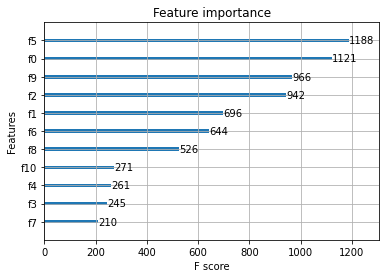

In [11]:
xgb.plot_importance(best_model)